In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
	accuracy_score,
	precision_score,
	recall_score,
	f1_score,
	confusion_matrix,
	roc_curve,
	auc,
	classification_report
)
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
def carregar_dados_csv(file):

	try:
		
		df_completo = pd.read_csv(file)

		return df_completo

	except FileNotFoundError:

		print(f"Erro: O arquivo '{file}' não foi encontrado.")
		print("Rode o ZeaMays para gerar o arquivo CSV.")
		return None

	except KeyError as e:

		print(f"Erro: Uma ou mais colunas não encontradas no arquivo: {e}")
		return None

	except Exception as e:

		print(f"Ocorreu um erro inesperado: {e}")
		return None

In [3]:
metricas = "df_metricas_seq.csv"

df_metricas = carregar_dados_csv(metricas)

if df_metricas is not None:
	print("\nHead do DataFrame:")
	print(df_metricas.shape)
	print(df_metricas.head())


Head do DataFrame:
(67686, 5766)
   Chr SourceAnnotation                                    COS      Start  \
0    1           APTEdb  Class II subclass 2/Helitron/Helitron  185134318   
1    1           APTEdb  Class II subclass 2/Helitron/Helitron  108502298   
2    9           APTEdb  Class II subclass 2/Helitron/Helitron   77998293   
3    4           APTEdb  Class II subclass 2/Helitron/Helitron  206727217   
4    8           APTEdb  Class II subclass 2/Helitron/Helitron  165674147   

         End Score Strand Phase  \
0  185151509     .      -     .   
1  108504248     .      -     .   
2   78002783     .      +     .   
3  206731508     .      +     .   
4  165674275     .      -     .   

                                          Attributes  \
0  TE-Score=0.714;Software=HelitronScanner;Length...   
1  TE-Score=0.428;Software=HelitronScanner;Length...   
2  TE-Score=0.714;Software=HelitronScanner;Length...   
3  TE-Score=0.428;Software=HelitronScanner;Length...   
4  TE-Score=

In [4]:
remover_colunas = ["Chr", "SourceAnnotation", "Start", "End", "Score", "Strand", "Phase", "Attributes", "label"]

df_modificado = df_metricas.drop(columns=remover_colunas)

print("\nDataFrame após remover colunas:")
print(df_modificado.shape)
print(df_modificado.head())


DataFrame após remover colunas:
(67686, 5757)
                                     COS  ZMays/Agrup\anf_fourier_average  \
0  Class II subclass 2/Helitron/Helitron                      1109.133954   
1  Class II subclass 2/Helitron/Helitron                       146.131903   
2  Class II subclass 2/Helitron/Helitron                       306.033744   
3  Class II subclass 2/Helitron/Helitron                       306.207420   
4  Class II subclass 2/Helitron/Helitron                        11.691824   

   ZMays/Agrup\anf_fourier_median  ZMays/Agrup\anf_fourier_maximum  \
0                       10.007322                     1.881748e+07   
1                        6.389373                     2.643780e+05   
2                        6.873558                     1.326329e+06   
3                        8.069504                     1.260339e+06   
4                        0.949723                     1.346578e+03   

   ZMays/Agrup\anf_fourier_minimum  ZMays/Agrup\anf_fourier_peak  \
0

In [5]:
coluna_alvo = 'COS'

In [6]:
def verfica_unique (df, coluna):
	
	if coluna in df.columns:

		contagem_valores = df[coluna].value_counts()

		print(f"Contagem de cada valor único na coluna '{coluna}':")
		print(contagem_valores)

		valores_unicos = df[coluna].unique()
		print(f"\nValores únicos na coluna '{coluna}':")
		print(valores_unicos)

		numero_de_valores_unicos = df[coluna].nunique()
		print(f"\nA coluna '{coluna}' possui {numero_de_valores_unicos} valores únicos distintos.")

	else:
		print(f"A coluna '{coluna}' não foi encontrada no DataFrame.")
		print("Colunas disponíveis:", df.columns.tolist())

verfica_unique(df_modificado, coluna_alvo)

Contagem de cada valor único na coluna 'COS':
COS
Class I/LTR/Gypsy                         20805
Class I/LTR/Copia                         11109
Class II subclass 2/Helitron/Helitron      5020
Class II subclass 2/MITE/MITE              4357
Class I/LTR/LARD                           3206
Class II subclass 1/TIR/PIF-Harbinger      3033
Class I/LTR/Unknown                        2914
Class II subclass 1/TIR/hAT                2363
Class II subclass 1/TIR/Harbinger          2007
Class II subclass 1/TIR/CMC-EnSpm          1562
Class II subclass 1/TIR/Unknown            1562
Class I/LINE/L1                            1485
Class II subclass 1/TIR/EnSpm-CACTA        1472
Class II subclass 1/TIR/MuDR               1387
Class II subclass 1/TIR/hAT-Ac             1175
Class II subclass 1/TIR/MuLE-MuDR           813
Class I/SINE/tRNA                           530
Class II subclass 1/TIR/TcMar-Stowaway      462
Class II subclass I/TIR/Unknown             401
Class II subclass 1/TIR/Tc1-Mariner   

In [7]:
def extrair_elemento_transponivel(texto):
  
	try:
		return texto.split('/')[1]
	except IndexError:
		return
	
df_modificado[coluna_alvo] = df_modificado[coluna_alvo].apply(extrair_elemento_transponivel)

verfica_unique(df_modificado, coluna_alvo)

Contagem de cada valor único na coluna 'COS':
COS
LTR         38484
TIR         17000
Helitron     5020
MITE         4357
LINE         2089
SINE          736
Name: count, dtype: int64

Valores únicos na coluna 'COS':
['Helitron' 'LINE' 'LTR' 'MITE' 'SINE' 'TIR']

A coluna 'COS' possui 6 valores únicos distintos.


In [8]:
ocorrencia = 1

contagens = df_modificado[coluna_alvo].value_counts()

valores_para_manter = contagens[contagens > ocorrencia].index

df_filtrado = df_modificado[df_modificado[coluna_alvo].isin(valores_para_manter)]

verfica_unique(df_filtrado, coluna_alvo)

Contagem de cada valor único na coluna 'COS':
COS
LTR         38484
TIR         17000
Helitron     5020
MITE         4357
LINE         2089
SINE          736
Name: count, dtype: int64

Valores únicos na coluna 'COS':
['Helitron' 'LINE' 'LTR' 'MITE' 'SINE' 'TIR']

A coluna 'COS' possui 6 valores únicos distintos.


In [9]:
df_filtrado.shape

(67686, 5757)

In [10]:
"""

# Encontra todas as colunas que começam com o prefixo "chaos_"
colunas_para_remover = [col for col in df_filtrado.columns if col.startswith('ZMays/Agrup\chaos_')]

# Cria um novo DataFrame sem essas colunas
df_filtrado = df_filtrado.drop(columns=colunas_para_remover)

print("Colunas removidas:", colunas_para_remover)
print("\nNovo formato do DataFrame:", df_filtrado.shape)
print("Primeiras linhas do DataFrame limpo:")
print(df_filtrado.head())

"""

<>:1: SyntaxWarning: invalid escape sequence '\c'
<>:1: SyntaxWarning: invalid escape sequence '\c'
C:\Users\Vinícius\AppData\Local\Temp\ipykernel_24980\1627118904.py:1: SyntaxWarning: invalid escape sequence '\c'
  """


'\n\n# Encontra todas as colunas que começam com o prefixo "chaos_"\ncolunas_para_remover = [col for col in df_filtrado.columns if col.startswith(\'ZMays/Agrup\\chaos_\')]\n\n# Cria um novo DataFrame sem essas colunas\ndf_filtrado = df_filtrado.drop(columns=colunas_para_remover)\n\nprint("Colunas removidas:", colunas_para_remover)\nprint("\nNovo formato do DataFrame:", df_filtrado.shape)\nprint("Primeiras linhas do DataFrame limpo:")\nprint(df_filtrado.head())\n\n'

In [11]:
df_filtrado.shape

(67686, 5757)

In [12]:
def treinar_avaliar_e_plotar(modelo, X_train, y_train, X_test, y_test, nome_modelo, feature_names):
	
	print(f"--- Treinando e Avaliando: {nome_modelo} ---")

	modelo.fit(X_train, y_train)

	y_pred = modelo.predict(X_test)
	y_pred_proba = modelo.predict_proba(X_test) # Probabilidades para a curva ROC

	# Avaliação
	print("\nRelatório de Classificação:")
	print(classification_report(y_test, y_pred))

	accuracy = accuracy_score(y_test, y_pred)
	precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
	recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
	f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

	print(f"Acurácia: {accuracy:.4f}")
	print(f"Precisão (ponderada): {precision:.4f}")
	print(f"Recall (ponderado): {recall:.4f}")
	print(f"F1-Score (ponderado): {f1:.4f}")

	# --- Plotagens ---
	plt.style.use('seaborn-v0_8-whitegrid')

	# Matriz de Confusão
	cm = confusion_matrix(y_test, y_pred)
	plt.figure(figsize=(8, 6))
	sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
				xticklabels=modelo.classes_, yticklabels=modelo.classes_)
	plt.title(f'Matriz de Confusão - {nome_modelo}')
	plt.ylabel('Verdadeiro')
	plt.xlabel('Previsto')
	plt.tight_layout()
	plt.show()

	# Curva ROC e AUC
	# Para multiclasse, a curva ROC é geralmente feita para cada classe (One-vs-Rest)
	# ou uma média. Para simplificar, se for binário, plota a curva para a classe positiva.
	# Se for multiclasse, podemos plotar para cada classe ou pular/adaptar.
	# Assumindo que y_test e classes do modelo estão como 0, 1, ... N-1
	
	n_classes = len(modelo.classes_)
	if n_classes == 2: # Classificação Binária

		y_probs_positive_class = y_pred_proba[:, 1]
		fpr, tpr, thresholds = roc_curve(y_test, y_probs_positive_class, pos_label=modelo.classes_[1])
		roc_auc = auc(fpr, tpr)

		plt.figure(figsize=(8, 6))
		plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
		plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
		plt.xlim([0.0, 1.0])
		plt.ylim([0.0, 1.05])
		plt.xlabel('Taxa de Falsos Positivos (FPR)')
		plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
		plt.title(f'Curva ROC - {nome_modelo}')
		plt.legend(loc="lower right")
		plt.tight_layout()
		plt.show()

	else: # Classificação Multiclasse (exemplo simplificado: micro-average ou pode ser por classe)
		print(f"\n{nome_modelo} é um classificador multiclasse ({n_classes} classes).")
		print("A plotagem da curva ROC para multiclasse pode ser feita por classe (OvR) ou com médias.")
		# Exemplo para plotar ROC para cada classe (One-vs-Rest)
		plt.figure(figsize=(10, 8))
		for i, class_label in enumerate(modelo.classes_):
			fpr, tpr, _ = roc_curve(y_test == class_label, y_pred_proba[:, i])
			roc_auc = auc(fpr, tpr)
			plt.plot(fpr, tpr, lw=2, label=f'ROC Classe {class_label} (AUC = {roc_auc:.2f})')
		
		plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
		plt.xlim([0.0, 1.0])
		plt.ylim([0.0, 1.05])
		plt.xlabel('Taxa de Falsos Positivos (FPR)')
		plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
		plt.title(f'Curva ROC Multiclasse (OvR) - {nome_modelo}')
		plt.legend(loc="lower right")
		plt.tight_layout()
		plt.show()


	# Importância das Features
	if hasattr(modelo, 'feature_importances_'):
		importances = modelo.feature_importances_
		indices = np.argsort(importances)[::-1]
		
		# Limitar o número de features no gráfico para melhor visualização
		num_features_to_plot = min(len(feature_names), 20)
		
		plt.figure(figsize=(12, max(6, num_features_to_plot * 0.3))) # Ajusta altura
		plt.title(f"Importância das Features - {nome_modelo} (Top {num_features_to_plot})")
		sns.barplot(x=importances[indices][:num_features_to_plot],
					y=[feature_names[i] for i in indices[:num_features_to_plot]])
		plt.xlabel("Importância Relativa")
		plt.ylabel("Feature")
		plt.tight_layout()
		plt.show()
	
	print(f"--- Avaliação de {nome_modelo} Concluída ---")
	return modelo # Retorna o modelo treinado


# --- Função para Random Forest ---
def treinar_random_forest(X_train, y_train, X_test, y_test, feature_names, **kwargs_rf):
	
	params_rf = {'n_estimators': 100, 'random_state': 42, 'min_samples_split': 2, 'min_samples_leaf':1}
	params_rf.update(kwargs_rf)

	rf_model = RandomForestClassifier(**params_rf)
	
	modelo_treinado = treinar_avaliar_e_plotar(rf_model, X_train, y_train, X_test, y_test, "Random Forest", feature_names)

	return modelo_treinado

# --- Função para XGBoost ---
def treinar_xgboost(X_train, y_train, X_test, y_test, feature_names, **kwargs_xgb):
	
	# Verifica se y_train e y_test são numéricos e não negativos
	if not (np.issubdtype(y_train.dtype, np.number) and np.all(y_train >= 0) and
			np.issubdtype(y_test.dtype, np.number) and np.all(y_test >= 0)):
		print("AVISO XGBoost: y_train e y_test devem ser arrays numéricos com classes codificadas de 0 a N-1.")
		print("         Considere usar sklearn.preprocessing.LabelEncoder na sua variável alvo antes de chamar esta função.")
		

	params_xgb = {
		'n_estimators': 100,
		'random_state': 42,
		'use_label_encoder': False,
		'eval_metric': 'logloss' # ou 'mlogloss' para multiclasse, ou 'auc' etc.
	}
	
	# Se for multiclasse, 'objective' comum é 'multi:softprob'
	num_classes = len(np.unique(y_train))
	if num_classes > 2:
		params_xgb['objective'] = 'multi:softprob' # Retorna probabilidades para cada classe
		params_xgb['eval_metric'] = 'mlogloss'
	else:
		params_xgb['objective'] = 'binary:logistic' # Retorna probabilidade da classe positiva
		params_xgb['eval_metric'] = 'logloss'

	params_xgb.update(kwargs_xgb)

	xgb_model = XGBClassifier(**params_xgb)
	
	modelo_treinado = treinar_avaliar_e_plotar(
		xgb_model, X_train, y_train, X_test, y_test, "XGBoost", feature_names
	)
	return modelo_treinado

def treinar_random_forest_optuna(X_train, y_train, X_test, y_test, feature_names, n_trials=50):

		def objetivo(trial):	

			params = {
				'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
				'max_depth': trial.suggest_int('max_depth', 4, 50),
				'min_samples_split': trial.suggest_int('min_samples_split', 2, 32),
				'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 32),
				'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
				'random_state': 42,
				'n_jobs': -1  # Usa todos os processadores disponíveis
			}


			modelo_rf = RandomForestClassifier(**params)
			modelo_rf.fit(X_train, y_train)

			y_pred = modelo_rf.predict(X_test)
			acuracia = accuracy_score(y_test, y_pred)

			return acuracia

		estudo = optuna.create_study(direction='maximize')
		estudo.optimize(objetivo, n_trials=n_trials)

		melhores_params = estudo.best_params
		print("Melhores hiperparâmetros encontrados:", melhores_params)
		print("Melhor acurácia (validação):", estudo.best_value)

		rf_model_final = RandomForestClassifier(**melhores_params, random_state=42, n_jobs=-1)

		modelo_treinado = treinar_avaliar_e_plotar(
			rf_model_final, X_train, y_train, X_test, y_test, "Random Forest (Otimizado com Optuna)", feature_names
		)

		return modelo_treinado

	# --- Exemplo de como usar a nova função ---
	# Supondo que X_train, y_train, X_test, y_test e feature_names já estão definidos:
	#
	# modelo_final_rf = treinar_random_forest_com_optuna(
	#     X_train, y_train, X_test, y_test, feature_names, n_trials=100
	# )


['Helitron' 'LINE' 'LTR' 'MITE' 'SINE' 'TIR']
[0 1 2 3 4 5]


In [13]:
nome_coluna_alvo = 'COS'

df_modelo = df_filtrado.copy()

# Amostragem de 10% do DataFrame filtrado para um pseudo-treinamento
# df_modelo = df_filtrado.sample(frac=0.02, random_state=42)

if nome_coluna_alvo not in df_modelo.columns:

	print(f"ERRO: Coluna alvo '{nome_coluna_alvo}' não encontrada no DataFrame!")
	
else:

	y_original = df_modelo[nome_coluna_alvo]
	X_original = df_modelo.drop(columns=[nome_coluna_alvo])
	
	print(f"\nVariável Alvo Selecionada: '{nome_coluna_alvo}' (Multiclasse)")
	print("-" * 50)

	# Codificar Features Categóricas em X (One-Hot Encoding)
	colunas_categoricas_X = X_original.select_dtypes(include=['object', 'category']).columns
	X_codificado = pd.get_dummies(X_original, columns=colunas_categoricas_X, drop_first=True)
	feature_names = X_codificado.columns.tolist()

	print("\nFeatures (X) após One-Hot Encoding (primeiras linhas):")
	print(X_codificado.head())
	print(f"Número de features após encoding: {X_codificado.shape[1]}")
	print("-" * 50)

	# Codificar Variável Alvo (y) para formato numérico 0..N-1
	le = LabelEncoder()
	y_codificada = le.fit_transform(y_original) # Converte strings/categorias para 0, 1, 2...

	class_names = le.classes_ # Salva os nomes originais das classes
	
	print(f"\nCodificação da Variável Alvo '{nome_coluna_alvo}':")
	print("Classes originais:", le.classes_)
	print("Classes codificadas (únicas):", np.unique(y_codificada))
	print("Alvo (y) após codificação (primeiras ocorrências):", y_codificada[:5])
	print("-" * 50)

	# Dividir em Dados de Treino e Teste
	try:

		X_train, X_test, y_train, y_test = train_test_split(X_codificado, y_codificada, test_size=0.25, random_state=42, stratify=y_codificada)

	except ValueError:

		print("Aviso: Não foi possível usar 'stratify'. Tentando sem.")

		X_train, X_test, y_train, y_test = train_test_split(X_codificado, y_codificada, test_size=0.25, random_state=42)

	print(f"\nDimensões dos conjuntos de treino/teste estabelecidas.")
	print("-" * 50)

"""
	# Treinar e Avaliar Modelos

	# Random Forest com Optuna

	modelo_final_rf_op = treinar_random_forest_optuna(X_train, y_train, X_test, y_test, feature_names, n_trials=100)
"""

""""
	# Random Forest

	modelo_rf_final = treinar_random_forest(
		X_train, y_train, X_test, y_test, feature_names,
		n_estimators=120, class_weight='balanced'
	)
	
	print("-" * 50)
	
	# XGBoost
	modelo_xgb_final = treinar_xgboost(X_train, y_train, X_test, y_test, feature_names,
									   n_estimators=120, learning_rate=0.1, max_depth=4)
	print("-" * 50)

	print("\n--- Análises Adicionais e Próximos Passos (Relembrando) ---")
	print("1. Comparação de Modelos.")
	print("2. Otimização de Hiperparâmetros (GridSearchCV, RandomizedSearchCV).")
	print("3. Validação Cruzada (Cross-Validation).")
	print("4. Análise de Erros (Matriz de Confusão).")
	print("5. Engenharia de Features.")
"""


Variável Alvo Selecionada: 'COS' (Multiclasse)
--------------------------------------------------

Features (X) após One-Hot Encoding (primeiras linhas):
   ZMays/Agrup\anf_fourier_average  ZMays/Agrup\anf_fourier_median  \
0                      1109.133954                       10.007322   
1                       146.131903                        6.389373   
2                       306.033744                        6.873558   
3                       306.207420                        8.069504   
4                        11.691824                        0.949723   

   ZMays/Agrup\anf_fourier_maximum  ZMays/Agrup\anf_fourier_minimum  \
0                     1.881748e+07                         0.002313   
1                     2.643780e+05                         0.001060   
2                     1.326329e+06                         0.002569   
3                     1.260339e+06                         0.003732   
4                     1.346578e+03                         0.003349  

'"\n\t# Random Forest\n\n\tmodelo_rf_final = treinar_random_forest(\n\t\tX_train, y_train, X_test, y_test, feature_names,\n\t\tn_estimators=120, class_weight=\'balanced\'\n\t)\n\t\n\tprint("-" * 50)\n\t\n\t# XGBoost\n\tmodelo_xgb_final = treinar_xgboost(X_train, y_train, X_test, y_test, feature_names,\n\t\t\t\t\t\t\t\t\t   n_estimators=120, learning_rate=0.1, max_depth=4)\n\tprint("-" * 50)\n\n\tprint("\n--- Análises Adicionais e Próximos Passos (Relembrando) ---")\n\tprint("1. Comparação de Modelos.")\n\tprint("2. Otimização de Hiperparâmetros (GridSearchCV, RandomizedSearchCV).")\n\tprint("3. Validação Cruzada (Cross-Validation).")\n\tprint("4. Análise de Erros (Matriz de Confusão).")\n\tprint("5. Engenharia de Features.")\n'

In [14]:
# salvar_rf_op = 'models/modelo_rf_final_op.joblib'
# joblib.dump(modelo_final_rf_op, salvar_rf_op)

"""
# --- ETAPA DE SALVAMENTO ---
salvar_rf = 'models/modelo_rf_final.joblib'
salvar_xgb = 'models/modelo_xgb_final.joblib'

# Salvar o modelo em um arquivo
joblib.dump(modelo_rf_final, salvar_rf)
joblib.dump(modelo_xgb_final, salvar_xgb)

# joblib.dump(le, 'models/modelo_label_encoder.joblib')
# joblib.dump(feature_names, 'models/modelo_features.joblib')

# Carregar o modelo do arquivo
modelo_rf = joblib.load(salvar_rf)
modelo_xgb = joblib.load(salvar_xgb)
"""

"\n# --- ETAPA DE SALVAMENTO ---\nsalvar_rf = 'models/modelo_rf_final.joblib'\nsalvar_xgb = 'models/modelo_xgb_final.joblib'\n\n# Salvar o modelo em um arquivo\njoblib.dump(modelo_rf_final, salvar_rf)\njoblib.dump(modelo_xgb_final, salvar_xgb)\n\n# joblib.dump(le, 'models/modelo_label_encoder.joblib')\n# joblib.dump(feature_names, 'models/modelo_features.joblib')\n\n# Carregar o modelo do arquivo\nmodelo_rf = joblib.load(salvar_rf)\nmodelo_xgb = joblib.load(salvar_xgb)\n"


Carregando modelo: models/modelo_rf.joblib...

==================== AVALIANDO: Random Forest ====================

RELATÓRIO DE CLASSIFICAÇÃO:

              precision    recall  f1-score   support

    Helitron       0.59      0.03      0.06      1255
        LINE       0.95      0.03      0.07       522
         LTR       0.74      0.83      0.78      9622
        MITE       0.16      0.04      0.06      1089
        SINE       0.74      0.11      0.19       184
         TIR       0.47      0.64      0.54      4250

    accuracy                           0.64     16922
   macro avg       0.61      0.28      0.28     16922
weighted avg       0.63      0.64      0.59     16922


PLOTANDO MATRIZ DE CONFUSÃO...


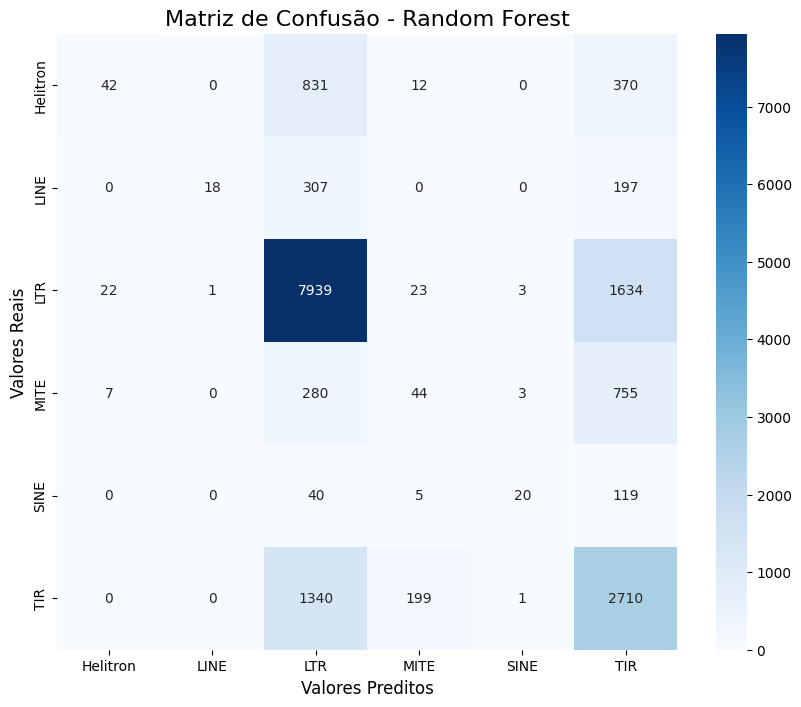


PLOTANDO IMPORTÂNCIA DAS FEATURES...


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_24980\1262279543.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')


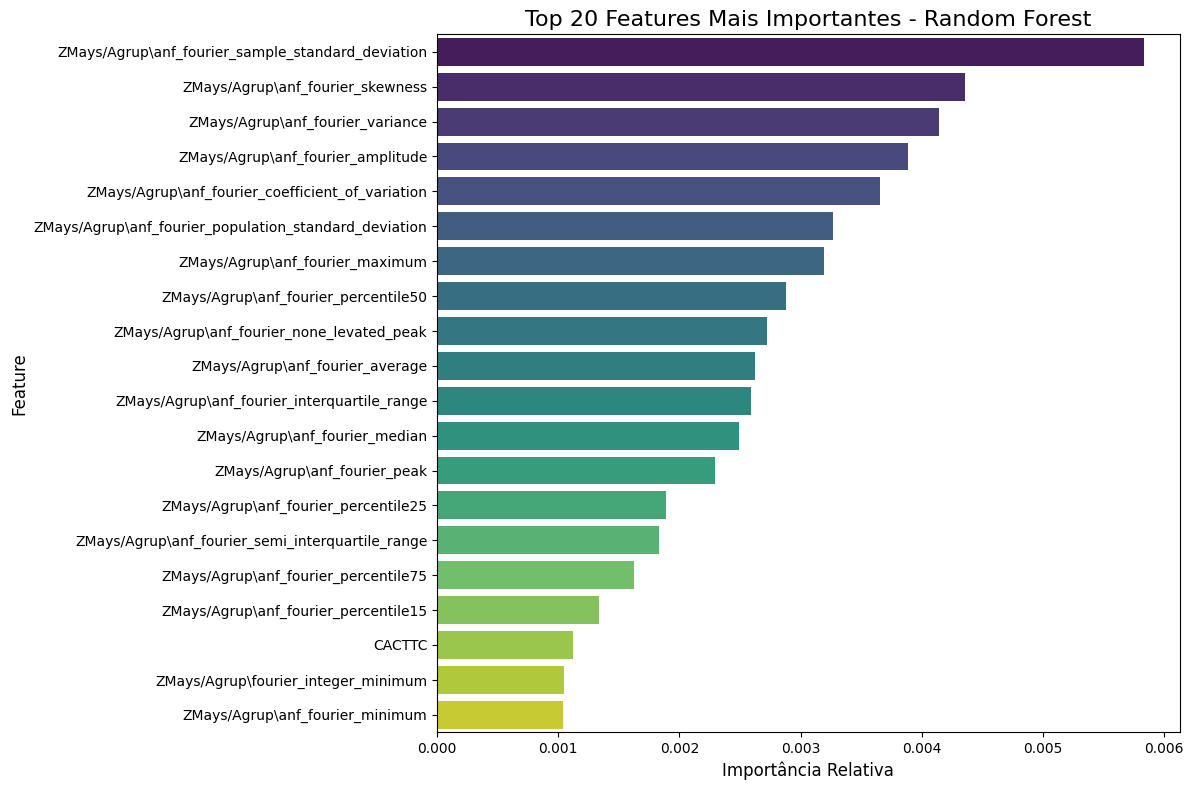


Carregando modelo: models/modelo_rf_op.joblib...

==================== AVALIANDO: Random Forest (Optuna) ====================

RELATÓRIO DE CLASSIFICAÇÃO:

              precision    recall  f1-score   support

    Helitron       1.00      0.00      0.00      1255
        LINE       0.00      0.00      0.00       522
         LTR       0.75      0.83      0.79      9622
        MITE       0.84      0.04      0.08      1089
        SINE       0.00      0.00      0.00       184
         TIR       0.48      0.71      0.57      4250

    accuracy                           0.65     16922
   macro avg       0.51      0.26      0.24     16922
weighted avg       0.67      0.65      0.60     16922


PLOTANDO MATRIZ DE CONFUSÃO...


c:\Users\Vinícius\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vinícius\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vinícius\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

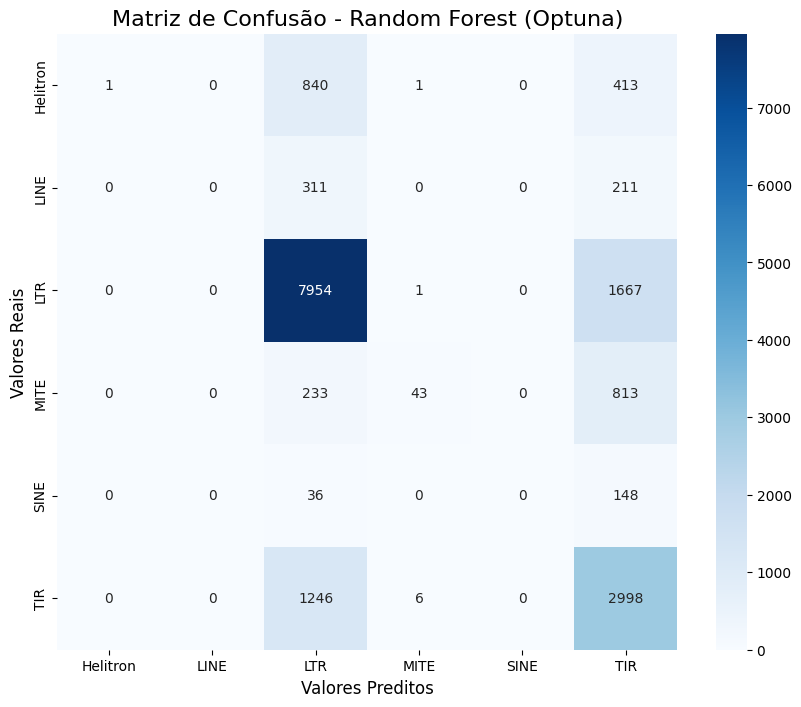


PLOTANDO IMPORTÂNCIA DAS FEATURES...


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_24980\1262279543.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')


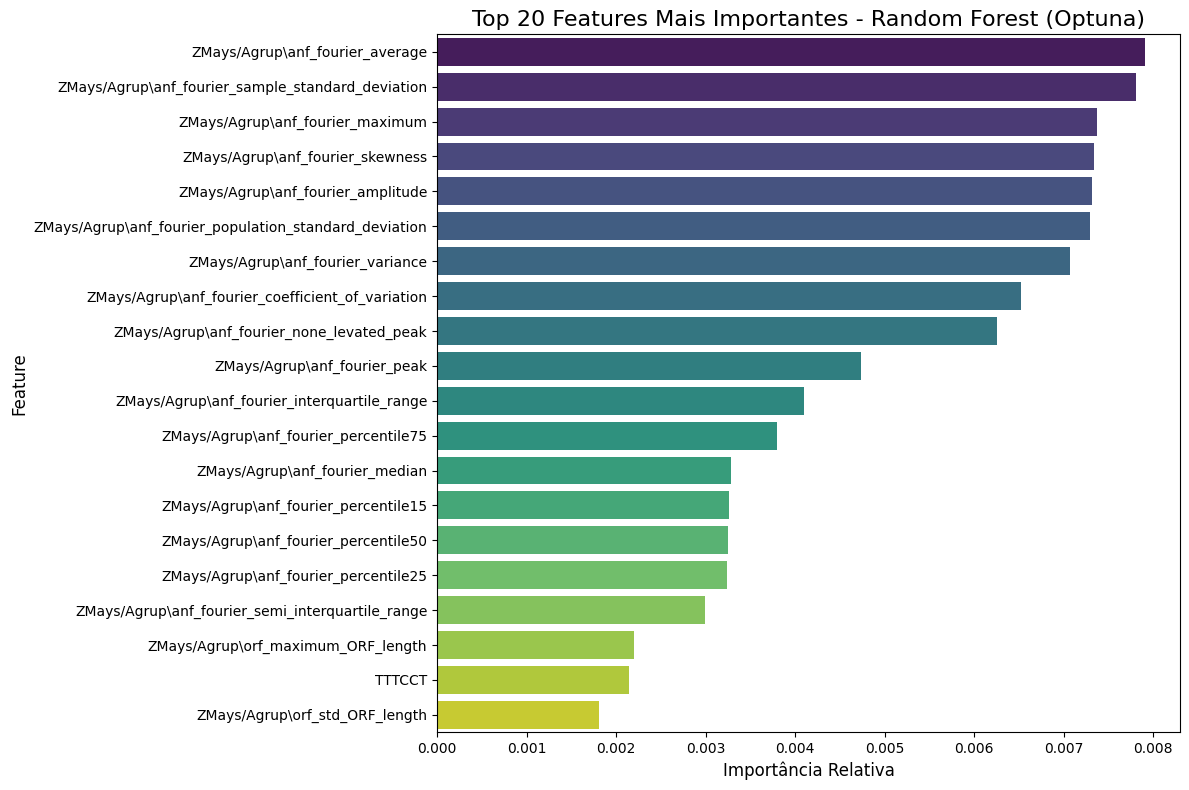


Carregando modelo: models/modelo_xgb.joblib...

==================== AVALIANDO: XGBoost ====================

RELATÓRIO DE CLASSIFICAÇÃO:

              precision    recall  f1-score   support

    Helitron       1.00      0.00      0.00      1255
        LINE       0.00      0.00      0.00       522
         LTR       0.71      0.84      0.77      9622
        MITE       0.69      0.04      0.07      1089
        SINE       0.50      0.01      0.01       184
         TIR       0.47      0.61      0.53      4250

    accuracy                           0.63     16922
   macro avg       0.56      0.25      0.23     16922
weighted avg       0.65      0.63      0.58     16922


PLOTANDO MATRIZ DE CONFUSÃO...


c:\Users\Vinícius\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vinícius\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Vinícius\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

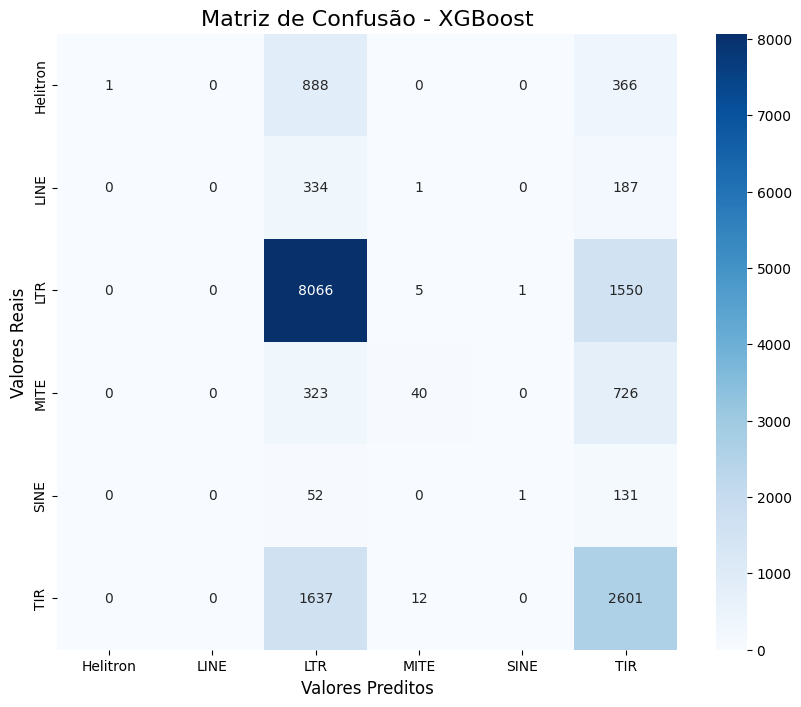


PLOTANDO IMPORTÂNCIA DAS FEATURES...


C:\Users\Vinícius\AppData\Local\Temp\ipykernel_24980\1262279543.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')


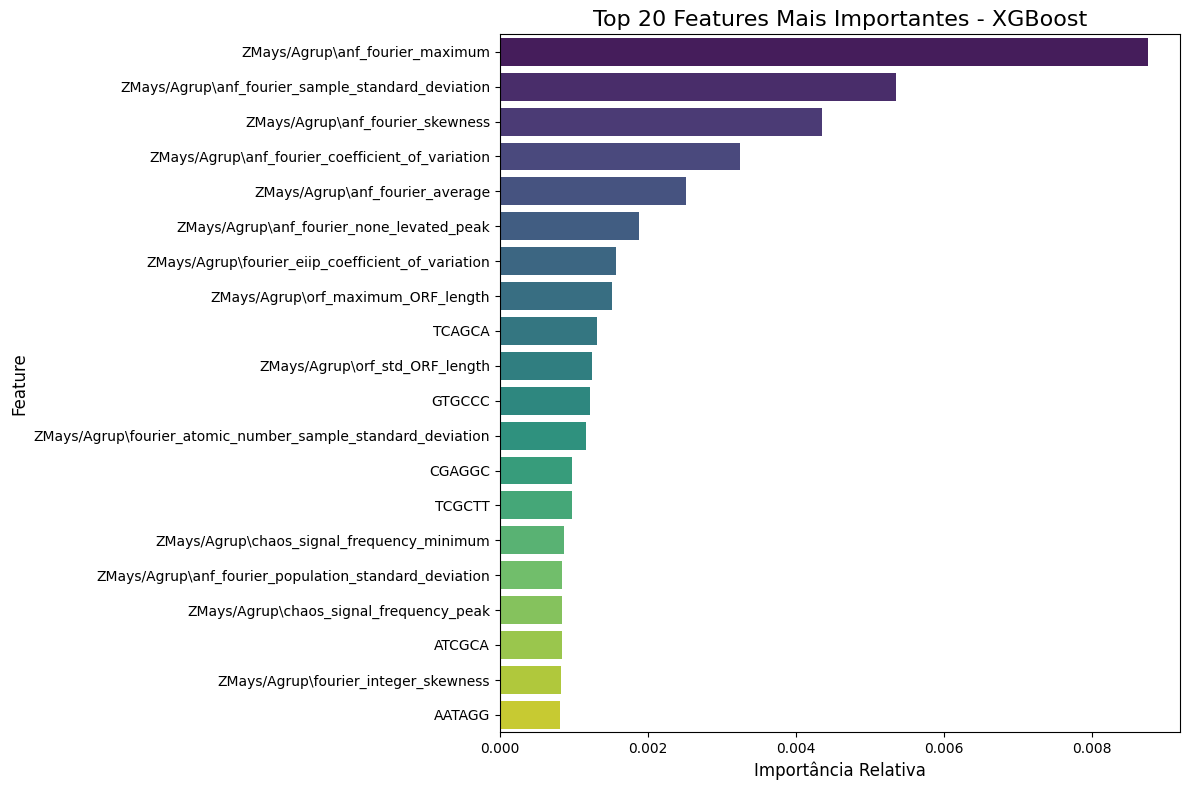

In [18]:
def avaliar_e_plotar_modelo(model, model_name, X_test, y_test, class_names, feature_names):
    """
    Recebe um modelo treinado e os dados de teste para gerar métricas e gráficos.class_names
    """
    print(f"\n{'='*20} AVALIANDO: {model_name} {'='*20}")

    # Fazer previsões com os dados de teste
    y_pred = model.predict(X_test)

    # a) Relatório de Classificação (Precisão, Recall, F1-Score)
    print("\nRELATÓRIO DE CLASSIFICAÇÃO:\n")
    print(classification_report(y_test, y_pred, target_names=class_names))

    # b) Matriz de Confusão
    print("\nPLOTANDO MATRIZ DE CONFUSÃO...")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Matriz de Confusão - {model_name}', fontsize=16)
    plt.ylabel('Valores Reais', fontsize=12)
    plt.xlabel('Valores Preditos', fontsize=12)
    plt.savefig(f'models/plots/matriz_confusao_{model_name.replace(" ", "_").lower()}.png')
    plt.show()

    # c) Importância das Features (se o modelo permitir)
    if hasattr(model, 'feature_importances_'):
        print("\nPLOTANDO IMPORTÂNCIA DAS FEATURES...")
        importances = model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False).head(20) # Pega as 20 mais importantes

        plt.figure(figsize=(12, 8))
        sns.barplot(x='importance', y='feature', data=feature_importance_df, palette='viridis')
        plt.title(f'Top 20 Features Mais Importantes - {model_name}', fontsize=16)
        plt.xlabel('Importância Relativa', fontsize=12)
        plt.ylabel('Feature', fontsize=12)
        plt.tight_layout()
        plt.savefig(f'models/plots/importancia_features_{model_name.replace(" ", "_").lower()}.png')
        plt.show()
    else:
        print(f"\nO modelo {model_name} não possui o atributo 'feature_importances_'.")


# ATENÇÃO: Substitua os nomes dos arquivos pelos nomes dos seus modelos salvos!
modelos_a_avaliar = {
    "Random Forest": "models/modelo_rf.joblib",
    "Random Forest (Optuna)": "models/modelo_rf_op.joblib",
    "XGBoost": "models/modelo_xgb.joblib"
}

for nome_modelo, caminho_arquivo in modelos_a_avaliar.items():
    try:
        # Carregar o modelo salvo
        print(f"\nCarregando modelo: {caminho_arquivo}...")
        modelo_carregado = joblib.load(caminho_arquivo)

        # Chamar a função de avaliação
        avaliar_e_plotar_modelo(
            model=modelo_carregado,
            model_name=nome_modelo,
            X_test=X_test,
            y_test=y_test,
            class_names=class_names,
            feature_names=feature_names
        )

    except FileNotFoundError:
        print(f"ERRO: Arquivo '{caminho_arquivo}' não encontrado. Por favor, verifique o nome e o caminho.")
    except Exception as e:
        print(f"Ocorreu um erro ao avaliar o modelo {nome_modelo}: {e}")